In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path="/content/drive/MyDrive/毕设"
os.chdir(path)
os.listdir(path)

['MIT-BIH-360',
 '文档',
 '模型',
 '数据CNN_LSTM',
 'CNN_LSTM_ECG数据泄露_未来加smote.ipynb',
 'CNN',
 'biLSTM.ipynb',
 'LSTM.ipynb',
 'CNN_biLSTM五分类.ipynb',
 'CNN_LSTM最新.ipynb',
 'CNN_LSTM最新.ipynb（副本）',
 'CNN（副本）_最新',
 'CNN_试验随机性',
 'CNN_注意力机制',
 'CNN_LSTM再次试验随机性.ipynb',
 'biLSTM.ipynb（副本）',
 'CNN模型13',
 'CNN为了得到模型13',
 'CNN_池化层后添加注意力机制',
 'CNN_精进数据集_CNN_LSTM',
 '精进数据集_CNN_BiLSTMgpu_目前最高',
 'biLSTM.ipynb精进数据集',
 'CNN_CBAM精进数据集_后续需修改损失函数',
 'CNN_SENET_LSTM精进数据集',
 'CNN_精进数据集_CNN本身GPU',
 'CNN_SENET精进数据集',
 'epoch=30 biLSTM.ipynb',
 'CNN_SENET_LSTM精进数据集_五折交叉验证.ipynb',
 'CNN_精进数据集_CNN本身GPU_五折交叉验证.ipynb',
 'epoch=30 biLSTM_画损失函数.ipynb',
 'CNN_SENET_LSTM精进数据集_画损失函数.ipynb',
 'CNN_精进数据集_CNN本身GPU_画损失函数.ipynb',
 'CNN_SENET精进数据集 epoch=30.ipynb',
 'CNN_精进数据集_CNN_做手脚的程序！',
 'resnet.ipynb',
 'CNN_SENET_LSTM精进数据集_提问chatgpt.ipynb',
 'resnet_大数据集.ipynb',
 'CNN大数据集.ipynb',
 'resnet_34_大数据集.ipynb',
 'CNN_SENET_LSTM大数据集.ipynb',
 'CNN_SENET_LSTM_五折交叉验证.ipynb',
 '精进数据集_CNN_BiLSTMgpu 30.ipynb',
 'CNN_SENET精进数据集_五折交叉验证.i

In [ ]:
#Set random seeds to ensure that the model is reproducible
import random
import numpy as np
import tensorflow as tf

random_seed = 42
random.seed(random_seed )  # set random seed for python
np.random.seed(random_seed )  # set random seed for numpy
tf.random.set_seed(random_seed )  # set random seed for tensorflow-cpu
os.environ['TF_DETERMINISTIC_OPS'] = '1' # set random seed for tensorflow-gpu
os.environ['PYTHONHASHSEED'] = str(random_seed)

In [ ]:
import tensorflow as tf

# Check that the GPU is available and let the model connect to the GPU for training
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices available. Training on CPU.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Training on GPU.")

Training on GPU.


In [ ]:
!pip install tensorflow-determinism

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.1 MB/s eta 0:00:00


In [ ]:
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
RATIO = 0.2

In [ ]:
# Denoising pre-processing of ECG signal using discrete wavelet transform
def denoise(data):
    # Wavelet decomposition of the input data, using the Daubechies 5 wavelet with a decomposition level of 9
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
    # setting threshold
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    # threshold processing on the detailed coefficients obtained from wavelet decomposition.
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)
    # processed coefficients for wavelet reconstruction
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [ ]:

def getDataSet(number, X_data, Y_data):
    ecgClassSet = ['N', 'A', 'V', 'L', 'R']
    # Read data
    record = wfdb.rdrecord('/content/drive/MyDrive/毕设/MIT-BIH-360/' + number, channel_names=['MLII'])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)
    # R wave position and corresponding label in ECG data record
    annotation = wfdb.rdann('/content/drive/MyDrive/毕设/MIT-BIH-360/' + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol
    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end
    # 5 categories（N、A、V、L、R）

    while i < j:
        try:
            # Rclass[i] represents the heartbeat category label.
            # Here, we extract the R-peak position (Rlocation) of the i-th heartbeat
            # and the corresponding arrhythmia category (Rclass[i]).
            # Convert ECG type labels 'N', 'A', 'V', 'L', and 'R' to numerical values
            # 0, 1, 2, 3, and 4, respectively, and store them in Y_data.
            lable = ecgClassSet.index(Rclass[i])
            # length = 300
            x_train = rdata[Rlocation[i] - 100:Rlocation[i] + 200]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            i += 1
    return


In [ ]:
def loadData():
    numberSet =['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
               '116', '117','118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208','209',
               '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
               '231', '232', '233', '234']
    dataSet = []
    lableSet = []
    print("Reading data...")
    # Retrieve the five types of heartbeats corresponding to the patients in numberSet
    for n in numberSet:
        getDataSet(n, dataSet, lableSet)
    print("Data reading completed")

    # Convert to numpy arrays and shuffle the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # Dataset and its label set
    X = train_ds[:, :300].reshape(-1, 300, 1)
    Y = train_ds[:, 300]

    # Testing set and its label set
    shuffle_index = np.random.permutation(len(X))

    # Set the size of the test set. RATIO represents the proportion of the test set in the dataset
    test_length = int(RATIO * len(shuffle_index))

    # Length of the test set
    test_index = shuffle_index[:test_length]

    # Length of the training set
    train_index = shuffle_index[test_length:]
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]

    # Create a MinMaxScaler object to normalize heartbeats
    scaler = MinMaxScaler()
    print('Starting normalization')

    # Normalize each sample's features in X_train
    for i in range(X_train.shape[0]):
        X_train[i, :, :] = scaler.fit_transform(X_train[i, :, :])

    # Normalize X_test using Min-Max normalization
    for j in range(X_test.shape[0]):
        X_test[j, :, :] = scaler.fit_transform(X_test[j, :, :])
    print('Normalization completed')

    # Set the target number of samples, selecting 2000 heartbeats per category
    target_samples_per_class = 2000
    for class_label in range(5):  # N, A, V, L, R (5 categories)
        # Find sample indices for the current category
        class_indices = np.where(Y_train == class_label)[0]

        # Randomly sample extra indices beyond the target number
        extra_indices = np.random.choice(class_indices, size=len(class_indices) - target_samples_per_class, replace=False)

        # Remove excess samples from X_train and Y_train
        X_train = np.delete(X_train, extra_indices, axis=0)
        Y_train = np.delete(Y_train, extra_indices, axis=0)

    target_samples_per_class_test = 500
    for class_label in range(5):  # N, A, V, L, R (5 categories)
        # Find sample indices for the current category
        class_indices = np.where(Y_test == class_label)[0]

        # Randomly sample extra indices beyond the target number
        extra_indices = np.random.choice(class_indices, size=len(class_indices) - target_samples_per_class_test, replace=False)

        # Remove excess samples from X_test and Y_test
        X_test = np.delete(X_test, extra_indices, axis=0)
        Y_test = np.delete(Y_test, extra_indices, axis=0)

    return X_train, Y_train, X_test, Y_test


In [ ]:
# SE attention mechanism module
def squeeze_excite_block(input_layer, ratio=16):
    # Get the number of channels in the input layer
    channels = input_layer.shape[-1]
    # Global average pooling
    se = tf.keras.layers.GlobalAveragePooling1D()(input_layer)
    # Reshape to fit the input of the fully connected layer (1, 1, channels)
    se = tf.keras.layers.Reshape((1, channels))(se)
    # Fully connected layer to model the relationship between channels, using ReLU activation function
    se = tf.keras.layers.Dense(channels // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    # Fully connected layer, using Sigmoid activation function to generate weights for each feature channel
    se = tf.keras.layers.Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = tf.keras.layers.Reshape((1, channels))(se)
    # Multiply the input layer with the weights to achieve feature channel re-weighting
    return tf.keras.layers.Multiply()([input_layer, se])

def buildModel():
    # Input layer, shape (300, 1)
    input_layer = tf.keras.layers.Input(shape=(300, 1))  # Modify the shape of the input layer
    # First convolutional layer, 128 filters, kernel size of 20, stride of 3, ReLU activation function, Glorot Normal initialization
    conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=20, strides=3, padding='same', activation=tf.nn.relu, kernel_initializer='glorot_normal')(input_layer)
    bn1 = tf.keras.layers.BatchNormalization()(conv1)
    se1 = squeeze_excite_block(bn1)  # SE attention mechanism module

    maxpool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=3)(se1)

    # Second convolutional layer, 32 filters, kernel size of 7, stride of 1, ReLU activation function, Glorot Normal initialization
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same', activation=tf.nn.relu, kernel_initializer='glorot_normal')(maxpool1)
    bn2 = tf.keras.layers.BatchNormalization()(conv2)
    se2 = squeeze_excite_block(bn2)  # SE attention mechanism module

    maxpool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(se2)

    # Third convolutional layer, 32 filters, kernel size of 10, stride of 1, ReLU activation function, Glorot Normal initialization
    conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=10, strides=1, padding='same', activation=tf.nn.relu, kernel_initializer='glorot_normal')(maxpool2)
    maxpool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)(conv3)

    # Bidirectional LSTM layer, output dimension of 10, returning full sequences
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True))(maxpool3)

    # Flatten layer, Dropout layer: dropout rate of 0.1, Fully connected layer: 10 output units, ReLU activation function,
    # Output layer: 5 output units, Softmax activation function
    flatten = tf.keras.layers.Flatten()(lstm)
    dropout = tf.keras.layers.Dropout(rate=0.1)(flatten)
    dense2 = tf.keras.layers.Dense(units=10, activation=tf.nn.relu)(dropout)
    output_layer = tf.keras.layers.Dense(units=5, activation=tf.nn.softmax)(dense2)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [ ]:
#confusion matrix
def plotHeatMap(Y_test, Y_pred, classes):
    con_mat = confusion_matrix(Y_test, Y_pred)

    plt.figure(figsize=(5, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [ ]:
def main():
    # X_train, Y_train represent the complete dataset and label set
    # X_test, Y_test represent the split test set and label set
    global X_train, Y_train, X_test, Y_test, Y_pred_classes
    X_train, Y_train, X_test, Y_test = loadData()
    print(X_train.shape)

    model = buildModel()
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy']
                  # Optimizer: Adam, using cross-entropy loss function
                  )

    # Training and validation
    history = model.fit(X_train, Y_train, epochs=30, batch_size=128, validation_split=RATIO)

    # Prediction
    Y_pred = model.predict(X_test)
    print(Y_pred)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    # Save the model
    # model.save('/content/drive/MyDrive/Thesis/Model/model_saved_300')

    # Plot training and validation loss curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Compute and plot the multi-class AUC-ROC curve
    y_pred_proba = model.predict(X_test)
    n_classes = y_pred_proba.shape[1]

    # Binarize the labels
    y_test_bin = label_binarize(Y_test, classes=list(range(n_classes)))

    # Compute and plot the ROC curve for each class
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion matrix
    # Pay attention to the labels
    plotHeatMap(Y_test, Y_pred_classes, ['N', 'A', 'V', 'L', 'R'])

    # Plot training and validation accuracy curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


正在读取数据...
读取数据完毕
开始归一化
归一化结束
(10000, 300, 1)
Epoch 1/30
63/63 [==============================] - 15s 40ms/step - loss: 0.9667 - accuracy: 0.6024 - val_loss: 1.6108 - val_accuracy: 0.2150
Epoch 2/30
63/63 [==============================] - 2s 25ms/step - loss: 0.3825 - accuracy: 0.8880 - val_loss: 1.6164 - val_accuracy: 0.1975
Epoch 3/30
63/63 [==============================] - 1s 24ms/step - loss: 0.2147 - accuracy: 0.9269 - val_loss: 1.6068 - val_accuracy: 0.2780
Epoch 4/30
63/63 [==============================] - 1s 16ms/step - loss: 0.1725 - accuracy: 0.9423 - val_loss: 1.6008 - val_accuracy: 0.2645
Epoch 5/30
63/63 [==============================] - 1s 15ms/step - loss: 0.1318 - accuracy: 0.9576 - val_loss: 1.5740 - val_accuracy: 0.3700
Epoch 6/30
63/63 [==============================] - 1s 15ms/step - loss: 0.1179 - accuracy: 0.9620 - val_loss: 1.5689 - val_accuracy: 0.3440
Epoch 7/30
63/63 [==============================] - 1s 19ms/step - loss: 0.1021 - accuracy: 0.9668 - val_los

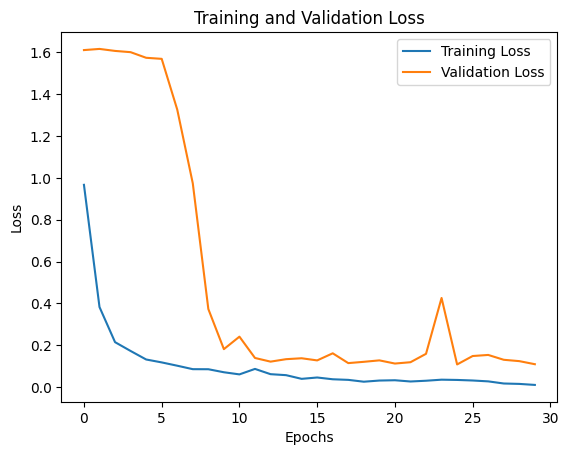

79/79 [==============================] - 0s 5ms/step


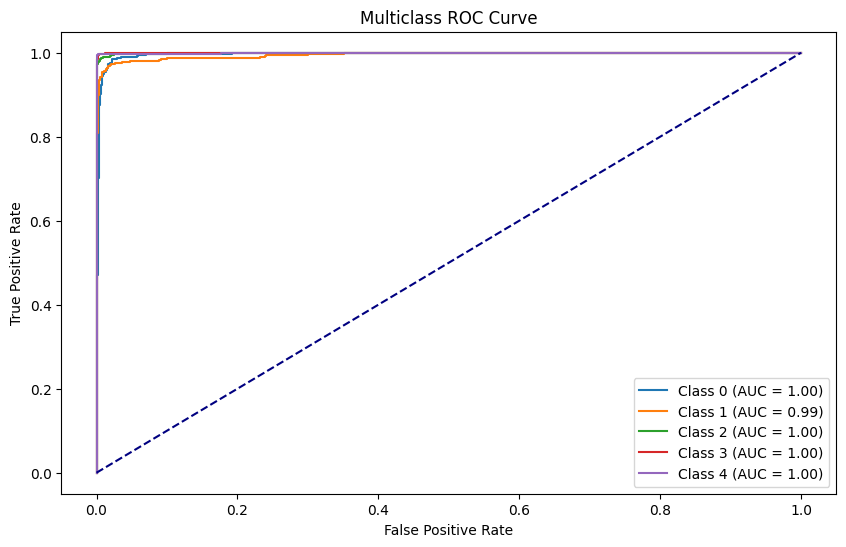

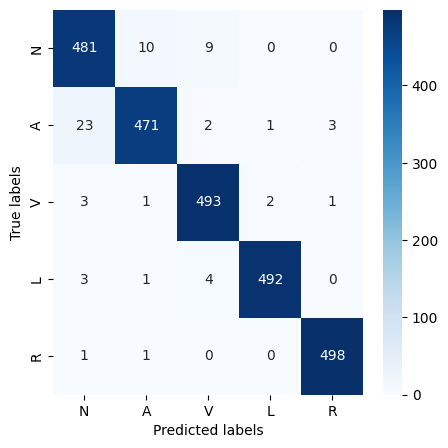

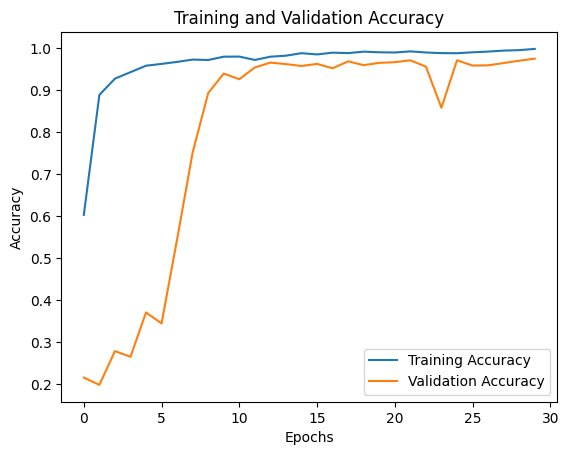

In [ ]:
if __name__ == '__main__':
    main()

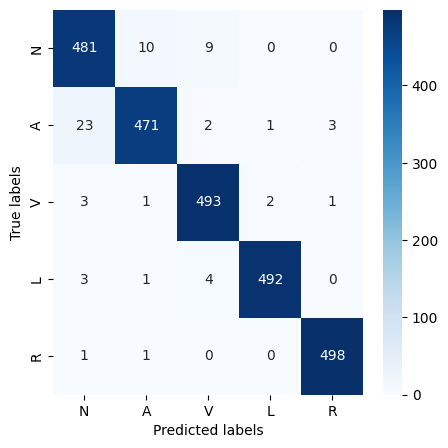

In [ ]:

plotHeatMap(Y_test, Y_pred_classes, ['N', 'A', 'V', 'L', 'R'])

In [ ]:
#分类报告
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       500
         1.0       0.97      0.94      0.96       500
         2.0       0.97      0.99      0.98       500
         3.0       0.99      0.98      0.99       500
         4.0       0.99      1.00      0.99       500

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500

